In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm # Last correct version: 3.7.0
plt.style.use('ggplot')
plt.rcParams['figure.figsize']= [15, 4]

df = pd.read_excel('data/generated_daily_features.xlsx', index_col=0)
display(df.head())

,P: debourrement - floraison,P: floraison - veraison,P: veraison - vendanges,Tn: debourrement - floraison,Tn: floraison - veraison,Tn: veraison - vendanges,Tx: debourrement - floraison,Tx: floraison - veraison,Tx: veraison - vendanges,Tm: debourrement - floraison,...,Floraison P,Floraison Heavy Rain,Floraison Tm,Floraison Tm-25,GDD10,Debourrement-floraison interval,Floraison-veraison interval,Veraison-Harvest interval,Stress,Log price
1961,108.1,115.2,13.9,7.197531,13.404167,13.940426,18.328395,23.823611,25.674468,12.606173,...,45.2,0,211.3,0,2245.9,80,71,46,92.55,7.079184
1962,92.5,77.3,90.6,9.028814,13.676923,11.901852,19.383051,24.992308,24.459259,14.201695,...,0.0,0,279.2,4,2328.9,58,64,53,56.15,6.156601
1963,156.4,125.6,146.5,8.962857,13.994915,11.726984,18.821429,23.569492,20.076190,13.800000,...,0.0,0,260.1,1,2068.2,69,58,62,-110.20,5.887723
1964,158.3,43.2,98.9,9.638028,13.713115,13.916000,19.998592,25.593443,24.876000,14.692958,...,0.0,0,254.5,0,2388.7,70,60,49,68.05,5.821989
1965,141.3,63.5,278.4,9.055556,13.461224,12.073684,18.291111,23.989796,20.459649,13.584444,...,0.0,0,276.4,2,1988.8,89,48,56,0.00,5.781001


# Building an exploratory model

In [2]:
from sklearn.preprocessing import StandardScaler

X = df.drop('Log price', axis=1)

#X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns).loc[1950:,:]

column_names = X.columns.to_list()
display(X.head())

y = df[['Log price']]

,P: debourrement - floraison,P: floraison - veraison,P: veraison - vendanges,Tn: debourrement - floraison,Tn: floraison - veraison,Tn: veraison - vendanges,Tx: debourrement - floraison,Tx: floraison - veraison,Tx: veraison - vendanges,Tm: debourrement - floraison,...,Floraison Wind,Floraison P,Floraison Heavy Rain,Floraison Tm,Floraison Tm-25,GDD10,Debourrement-floraison interval,Floraison-veraison interval,Veraison-Harvest interval,Stress
1961,108.1,115.2,13.9,7.197531,13.404167,13.940426,18.328395,23.823611,25.674468,12.606173,...,2.753333,45.2,0,211.3,0,2245.9,80,71,46,92.55
1962,92.5,77.3,90.6,9.028814,13.676923,11.901852,19.383051,24.992308,24.459259,14.201695,...,2.313333,0.0,0,279.2,4,2328.9,58,64,53,56.15
1963,156.4,125.6,146.5,8.962857,13.994915,11.726984,18.821429,23.569492,20.076190,13.800000,...,3.173333,0.0,0,260.1,1,2068.2,69,58,62,-110.20
1964,158.3,43.2,98.9,9.638028,13.713115,13.916000,19.998592,25.593443,24.876000,14.692958,...,2.786667,0.0,0,254.5,0,2388.7,70,60,49,68.05
1965,141.3,63.5,278.4,9.055556,13.461224,12.073684,18.291111,23.989796,20.459649,13.584444,...,3.366667,0.0,0,276.4,2,1988.8,89,48,56,0.00


## Findings:

- 

In [3]:
GOOD_FEATURES = ['Stress', 'P']
walk_coeffs = GOOD_FEATURES
scalar_coeffs = []

def run_HMC(walk_coeffs, scalar_coeffs, X_model, y_model, n_samples=2000):
    with pm.Model() as model:
        #sigma_coeffs = pm.Exponential('sigma coeffs', 1/.01, testval=1) # Random walk jump size
        #sigma_intercept = pm.Exponential('sigma intercept', 1/.01, testval=1) # Random walk jump size
        sigma_coeffs = 0.013
        sigma_intercept = 0.055
        #nu = pm.Exponential('nu', 1./0.2) # Observation noise
        nu = 0.255  
        
        coeffs = [(pm.GaussianRandomWalk(coeff_name, mu=0, sigma=sigma_coeffs, shape=len(y_model)), coeff_name) \
                    for coeff_name in walk_coeffs] + \
                 [(pm.Normal(coeff_name, mu=0, sigma=0.3), coeff_name) \
                    for coeff_name in scalar_coeffs]

        intercept = pm.GaussianRandomWalk('intercept', mu=0, sigma=sigma_intercept, shape=len(y_model))
        
        mu = 6 + intercept 
        for (coeff, coeff_name) in coeffs:
            mu += coeff * X_model[coeff_name]
            
        observed = pm.Normal('observed', mu, sd=nu, observed=y_model['Log price'])
        trace = pm.sample(n_samples,chains=2, target_accept=0.99, max_treedepth=12)
    return trace

In [4]:
def extract_quantities_from_trace(trace, burn, features):
    coeff_list = [coeff for coeff in ['intercept']+features]
    mean, high_95, low_95 = {}, {}, {}
    for coeff in coeff_list:
        mean[coeff] = np.mean(trace[coeff], axis=0)
        high_95[coeff] = np.quantile(trace[coeff], 0.975, axis=0)
        low_95[coeff] = np.quantile(trace[coeff], 0.025, axis=0)
    return mean, high_95, low_95

def extract_mean_from_trace(trace, burn, features):
    coeff_list = [coeff for coeff in ['intercept']+features]
    mean = {}
    for coeff in coeff_list:
        mean[coeff] = np.mean(trace[coeff], axis=0)
    return mean

C:\Users\Rico\anaconda3\lib\site-packages\pymc3\model.py:1331: UserWarning: Data in observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [observed_missing, intercept, Square Tm Growing Season, Tm Growing Season]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 5000/5000 [24:26<00:00,  3.41draws/s]
The acceptance probability does not match the target. It is 0.9522639351983349, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


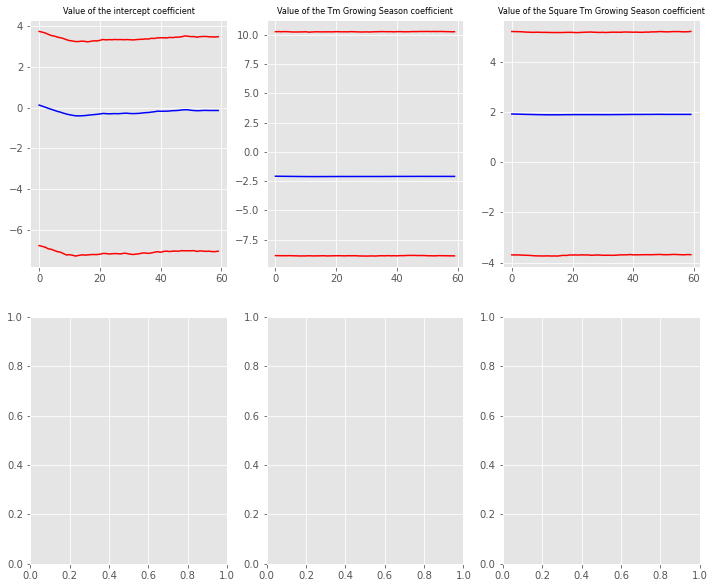

In [11]:
trace_global = run_HMC(GOOD_FEATURES, [], X, y)
mean_global, high_95_global, low_95_global = extract_quantities_from_trace(trace_global, 1000, GOOD_FEATURES)

coeffs = ['intercept'] + walk_coeffs + scalar_coeffs

f, axs = plt.subplots(len(coeffs)//3+1, 3)
f.set_size_inches(12,10)
for i in range(len(coeffs)):
    coeff_name = coeffs[i]
    subplot = axs[i//3, i%3]
    if coeff_name in scalar_coeffs:
        subplot.plot([mean_global[coeff_name]]*2, color='blue')
        subplot.plot([high_95_global[coeff_name]]*2, color='r')
        subplot.plot([low_95_global[coeff_name]]*2, color='r')
    else:
        subplot.plot(mean_global[coeff_name], color='blue')
        subplot.plot(high_95_global[coeff_name], color='r')
        subplot.plot(low_95_global[coeff_name], color='r')
    subplot.set_title('Value of the '+coeff_name+' coefficient', fontsize=8)
plt.show()

So far, this looks really good. Notice how the harvest temperature decreases to 0: a quadratic effect could be reached.

## Plotting results

In [12]:
pm.traceplot(trace_global['nu'].T)


KeyError: 'Unknown variable nu'

In [18]:
X_vintage = X
vintage_index = X_vintage.index.values

mean = extract_mean_from_trace(trace_global, 1000, GOOD_FEATURES)
predictions=[]

for vintage in range(1994, 2016):
    prediction = 6 + mean['intercept'][vintage-1961]
    for coeff in scalar_coeffs:
        prediction += mean[coeff] * X_vintage[coeff][vintage]
    for coeff in walk_coeffs:
        prediction += mean[coeff][vintage-1961] * X_vintage[coeff][vintage]
    predictions.append(prediction)

full_predictions=[]
for vintage in range(1961, 2016):
    prediction = 6 + mean['intercept'][vintage-1961]
    for coeff in scalar_coeffs:
        prediction += mean[coeff] * X_vintage[coeff][vintage]
    for coeff in walk_coeffs:
        prediction += mean[coeff][vintage-1961] * X_vintage[coeff][vintage]
    full_predictions.append(prediction)

NameError: name 'trace_global' is not defined

In [19]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

y = y.loc[1961:2015]

plt.plot(range(1994, 2016), predictions, color='r')
plt.plot(y['Log price'], color='g')
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions, y.loc[1994:2015, 'Log price']).correlation)
print('Spearman correlation between results and real log prices / full: \n', spearmanr(full_predictions, y['Log price']).correlation)

print('\nR2 between results and real log prices: \n', r2_score(predictions, y.loc[1994:2015, 'Log price']))
print('R2 between results and real log prices / full: \n', r2_score(full_predictions, y['Log price']))

print('\nMAE between results and real log prices: \n', np.mean(np.abs(predictions - y.loc[1994:2015, 'Log price'])))
print('MAE between results and real log prices / full: \n', np.mean(np.abs(full_predictions - y['Log price'])))

NameError: name 'predictions' is not defined

<AxesSubplot:>

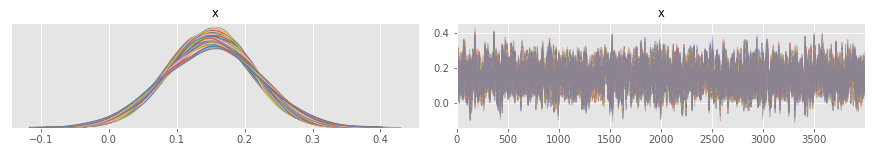

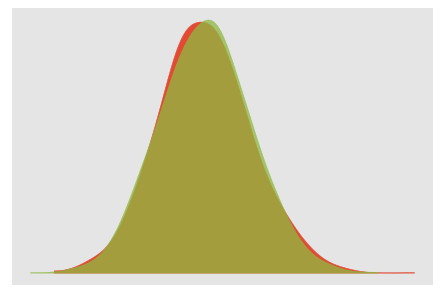

In [63]:
import warnings
warnings.filterwarnings("ignore")
pm.traceplot(trace_global['Stress'].T)

az.summary(trace_global)['r_hat']

pm.energyplot(trace_global, legend=False, figsize=(6, 4))

# Ante 1994 model prediction

In [6]:
X_ante = X.loc[1961:1993, :]
y_ante = y.loc[1961:1993, :]
GOOD_FEATURES = ['P: veraison - vendanges', 'Stress']
trace_ante = run_HMC(GOOD_FEATURES, [], X_ante, y_ante)
mean_ante_1, high_95, low_95 = extract_quantities_from_trace(trace_ante, 1000, GOOD_FEATURES)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, Stress, P: veraison - vendanges]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 5000/5000 [03:33<00:00, 23.38draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
X_ante = X.loc[1961:2004, :]
y_ante = y.loc[1961:2004, :]
trace_ante = run_HMC(GOOD_FEATURES, [], X_ante, y_ante)
mean_ante_2, high_95, low_95 = extract_quantities_from_trace(trace_ante, 1000, GOOD_FEATURES)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, Stress, P: veraison - vendanges]
Sampling 2 chains:  73%|████████████████████████████████████████▋               | 3628/5000 [02:19<00:52, 26.13draws/s]

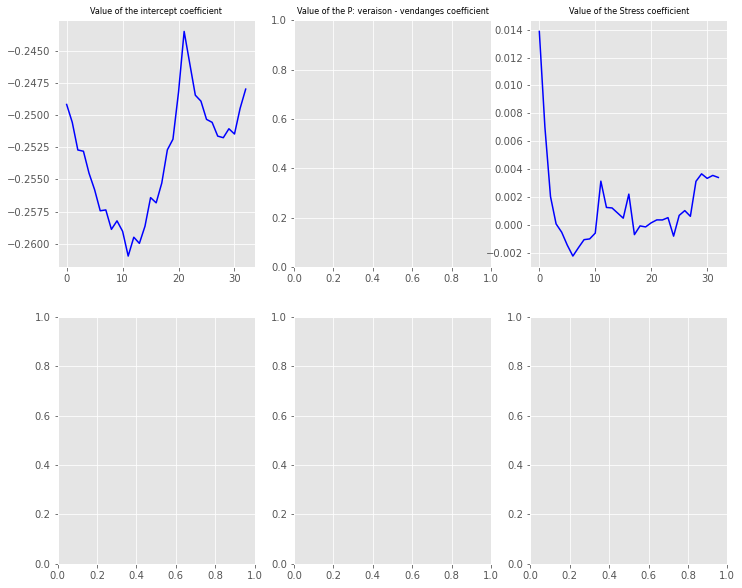

In [7]:
all_names = ['intercept'] + GOOD_FEATURES

f, axs = plt.subplots(len(all_names)//3+1, 3)
f.set_size_inches(12,10)
for i in range(len(all_names)):
    coeff_name = all_names[i]
    subplot = axs[i//3, i%3]
    if coeff_name == 'intercept':
        subplot.plot(mean_ante_1[coeff_name], color='blue')
        #subplot.plot(mean_ante_2[coeff_name], color='orange')
        #subplot.plot(high_95_global[coeff_name], color='r')
        #subplot.plot(low_95_global[coeff_name], color='r')
        #subplot.plot(mean_global[coeff_name], color='green')
    if coeff_name in scalar_coeffs:
        subplot.plot([mean_ante_1[coeff_name]]*2, color='blue')
        #subplot.plot([mean_ante_2[coeff_name]]*2, color='orange')
        #subplot.plot([high_95_global[coeff_name]]*2, color='r')
        #subplot.plot([low_95_global[coeff_name]]*2, color='r')
        #subplot.plot([mean_global[coeff_name]]*2, color='green')
    elif coeff_name in walk_coeffs:
        subplot.plot(mean_ante_1[coeff_name], color='blue')
        #subplot.plot(mean_ante_2[coeff_name], color='orange')
        #subplot.plot(high_95_global[coeff_name], color='r')
        #subplot.plot(low_95_global[coeff_name], color='r')
        #subplot.plot(mean_global[coeff_name], color='green')

    subplot.set_title('Value of the '+coeff_name+' coefficient', fontsize=8)
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

def extrapolate_coeffs(coeffs, model_year_range, target_vintage):
    line = LinearRegression()
    #line.fit(model_year_range, coeffs)
    line.fit(model_year_range[-15:], coeffs[-15:])

    #return (np.mean(coeffs[-5:]))
    return line.predict(np.array(target_vintage).reshape(1,-1))


predictions_1 = []
FIRST = 1961
LAST = 1993
for vintage in range(1994, 2016):
    prediction = 6 + extrapolate_coeffs(mean_ante_1['intercept'], np.arange(FIRST, LAST+1).reshape(-1,1), vintage)
    for coeff in scalar_coeffs:
        prediction += mean_ante_1[coeff] * X.loc[vintage, coeff]
    for coeff in walk_coeffs:
        prediction += extrapolate_coeffs(mean_ante_1[coeff], np.arange(FIRST, LAST+1).reshape(-1,1), vintage) * X.loc[vintage, coeff]
    predictions_1.append(prediction)
    
#predictions_2 = []
#FIRST = 1961
#LAST = 2004
#for vintage in range(2005, 2016):
#    prediction = 6 + extrapolate_coeffs(mean_ante_2['intercept'], np.arange(FIRST, LAST+1).reshape(-1,1), vintage)
#    for coeff in scalar_coeffs:
#        prediction += mean_ante_2[coeff] * X.loc[vintage, coeff]
#    for coeff in walk_coeffs:
#        prediction += extrapolate_coeffs(mean_ante_2[coeff], np.arange(FIRST, LAST+1).reshape(-1,1), vintage) * X.loc[vintage, coeff]
#    predictions_2.append(prediction)
    
y_test = y.loc[1994:2015]
plt.plot(range(1994, 2016), predictions_1, color='blue')
#plt.plot(range(2005, 2016), predictions_2, color='orange')
plt.plot(y_test['Log price'], color='g')

print('Spearman correlation between results and real log prices: \n', spearmanr(predictions_1, y.loc[1994:2015, 'Log price']).correlation)
#print('Spearman correlation between results and real log prices, 1994 model, second part: \n', spearmanr(predictions_1[-11:], y.loc[2005:2015, 'Log price']).correlation)
#print('Spearman correlation between results and real log prices, 2005 model, second part: \n', spearmanr(predictions_2, y.loc[2005:2015, 'Log price']).correlation)
#print('Spearman correlation between results and real log prices, concatenated: \n', spearmanr(predictions_1[:-11]+predictions_2, y.loc[1994:2015, 'Log price']).correlation)

#print('\nR2 between results and real log prices: \n', r2_score(predictions, y.loc[1994:2015, 'Log price']))

#print('\nMAE between results and real log prices: \n', np.mean(np.abs(predictions - y.loc[1994:2015, 'Log price'])))

KeyError: 'P'

Avec juste stress et P: veraison - vendanges, extrapolation sur 20 ans: 0.72

Avec en plus CI: debourrement floraison, 0.71

Avec juste stress: 0.73

# All mobile coeffs predictive model

The procedure will go as follows to predict the quality of one year: the HMC model will be run for up to the predicted model, the mean will then be interpolated by a polynomial, and the prolongation of the said polynomial will finally give the value of the coefficients for the next year, thus leading to a prediction.

In [30]:
def get_HMC_mean_curves(X, y, vintage, fixed_coeffs=None):
    print('Building curves for vintage ', vintage)
    X_vintage = X.loc[:vintage-1, :]
    y_vintage = y.loc[:vintage-1, :]
    
    with pm.Model() as model:
        #sigma_coeffs = pm.Exponential('sigma coeffs', 1/.01, testval=1) # Random walk jump size
        #sigma_intercept = pm.Exponential('sigma intercept', 1/.01, testval=1) # Random walk jump size
        sigma_coeffs = 0.013
        sigma_intercept = 0.055
        #nu = pm.Exponential('nu', 1./0.2) # Observation noise
        nu = 0.255
        
        walk_coeffs = GOOD_FEATURES
        scalar_coeffs = []    
    
        coeffs = [(pm.GaussianRandomWalk(coeff_name, mu=0, sigma=sigma_coeffs, shape=len(y_vintage)), coeff_name) \
                for coeff_name in walk_coeffs] + \
             [(pm.Normal(coeff_name, mu=0, sigma=0.3), coeff_name) \
                for coeff_name in scalar_coeffs]

        intercept = pm.GaussianRandomWalk('intercept', mu=0, sigma=sigma_intercept, shape=len(y_vintage))
    
        
        mu = 6 + intercept 
        for (coeff, coeff_name) in coeffs:
            mu += coeff * X_vintage[coeff_name]
            
        observed = pm.Normal('observed', mu, sd=nu, observed=y_vintage['Log price'])
        trace = pm.sample(2500,chains=2, target_accept=0.9)
        
    mean_dict = extract_mean_from_trace(trace, 1500, model)
    return mean_dict

In [133]:
HMC = {}
y = df[['Log price']]

for vintage in range(1994, 2018):
    HMC[vintage]= get_HMC_mean_curves(X,y, vintage)

Building curves for vintage  1994


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:10<00:00, 46.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  1995


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:06<00:00, 47.62draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  1996


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:07<00:00, 47.10draws/s]


Building curves for vintage  1997


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:14<00:00, 44.57draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  1998


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:11<00:00, 45.80draws/s]


Building curves for vintage  1999


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:16<00:00, 44.04draws/s]


Building curves for vintage  2000


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:14<00:00, 44.50draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:29<00:00, 40.06draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2002


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:24<00:00, 41.39draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2003


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:22<00:00, 42.03draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2004


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:16<00:00, 43.89draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2005


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:24<00:00, 41.63draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2006


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:23<00:00, 41.90draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2007


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:26<00:00, 40.86draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2008


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:29<00:00, 40.05draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2009


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:31<00:00, 39.60draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2010


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:35<00:00, 38.50draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2011


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:29<00:00, 40.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2012


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:32<00:00, 39.29draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2013


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:39<00:00, 37.55draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2014


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:39<00:00, 37.53draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2015


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:41<00:00, 37.17draws/s]
The number of effective samples is smaller than 25% for some parameters.


Building curves for vintage  2016


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:35<00:00, 38.67draws/s]


Building curves for vintage  2017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, DTR: veraison - vendanges, P: veraison - vendanges, Stress]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [02:35<00:00, 38.64draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [134]:
def extrapolate_next_coefficients(vintage_index, mean_dict):
    next_coeff_values={}
    for coeff in mean_dict.keys():
        z = np.polyfit(vintage_index[-10:], mean_dict[coeff][-10:], 2)
        p = np.poly1d(z)
        plt.plot(vintage_index, mean_dict[coeff], color='green')
        plt.plot(vintage_index[-10:], p(vintage_index)[-10:], color='orange')
        plt.show()
        next_coeff_values[coeff] = p(vintage_index[-1]+1)
    return next_coeff_values

In [135]:
def predict_from_HMC_curves(HMC, HMC_stop_date, vintage, plot=False):
    #print('Predicting for vintage: ', vintage)
    mean_HMC = HMC[HMC_stop_date]

    vintage_index = range(1950, HMC_stop_date)
        
    if plot:
        f, axs = plt.subplots((len(mean_HMCs.keys())-len(scalar_coeffs))//3, 3)

    next_coeff_values={}
    coeff_names = list(mean_HMC.keys())
    
    for i in range(len(coeff_names)):
        coeff = coeff_names[i]
        if coeff in scalar_coeffs:
            next_coeff_values[coeff] = mean_HMC[coeff]
        else:
            z = np.polyfit(vintage_index[-10:], mean_HMC[coeff][-10:], 1)
            p = np.poly1d(z)
            next_coeff_values[coeff] = np.mean(mean_HMC[coeff][-10:])# p(vintage) #    
        
            if plot:
                subplot = axs[i//3, i%3]
                subplot.plot(vintage_index, mean_HMC[coeff], color='green')
                subplot.plot(vintage_index[-20:], p(vintage_index)[-20:], color='orange')
                subplot.set_title(coeff)

    plt.show()
        

    return next_coeff_values

In [136]:
predictions=[]
coeff_record = {}
for coeff_name in scalar_coeffs + walk_coeffs + ['intercept']:
    coeff_record[coeff_name] = []


for vintage in range(1994, 2005):
    next_coeff_values = predict_from_HMC_curves(HMC, vintage, vintage, plot=False)
    if vintage==1994:
        next_coeff_values_1994 = next_coeff_values
    prediction = 6 + next_coeff_values['intercept']
    for coeff in scalar_coeffs + walk_coeffs:
        prediction += next_coeff_values[coeff] * X.loc[vintage, str(coeff)]
        
    for coeff in next_coeff_values.keys():
        
        coeff_record[coeff].append(next_coeff_values[coeff])
    
    predictions.append(prediction)
    
print(coeff_record)

{'Stress': [0.1644776873147233, 0.166075071957316, 0.16754364672881558, 0.14946503583264137, 0.15401577806930467, 0.1550358908591702, 0.1416828422004679, 0.16796754152072957, 0.1618915168511193, 0.15313930047855545, 0.15111394110398274], 'P: veraison - vendanges': [-0.07723362673505359, -0.07543054132955586, -0.0786405427387312, -0.08580430971549591, -0.08349070361700156, -0.07486059923848232, -0.0650632710171846, -0.07539300401190265, -0.07097682747595227, -0.07197670366783401, -0.0695291895282438], 'DTR: veraison - vendanges': [-0.04801626133052494, -0.041969921692372056, -0.045293193966566954, -0.031868006850891056, -0.03368790372899842, -0.027096499856584643, -0.01556256505293312, -0.013733638109913121, -0.007587542771924942, 0.005030192307575641, 0.004905675858560806], 'intercept': [-0.3186990743626027, -0.3259971608971604, -0.3206288035034885, -0.2823853689672736, -0.291154559517932, -0.26247180313548985, -0.23854146976654592, -0.17973982954714757, -0.18424247871532684, -0.188987

[0.1644776873147233, 0.166075071957316, 0.16754364672881558, 0.14946503583264137, 0.15401577806930467, 0.1550358908591702, 0.1416828422004679, 0.16796754152072957, 0.1618915168511193, 0.15313930047855545, 0.15111394110398274]
[-0.07723362673505359, -0.07543054132955586, -0.0786405427387312, -0.08580430971549591, -0.08349070361700156, -0.07486059923848232, -0.0650632710171846, -0.07539300401190265, -0.07097682747595227, -0.07197670366783401, -0.0695291895282438]
[-0.04801626133052494, -0.041969921692372056, -0.045293193966566954, -0.031868006850891056, -0.03368790372899842, -0.027096499856584643, -0.01556256505293312, -0.013733638109913121, -0.007587542771924942, 0.005030192307575641, 0.004905675858560806]
[-0.3186990743626027, -0.3259971608971604, -0.3206288035034885, -0.2823853689672736, -0.291154559517932, -0.26247180313548985, -0.23854146976654592, -0.17973982954714757, -0.18424247871532684, -0.18898753156230103, -0.18923662843023656]


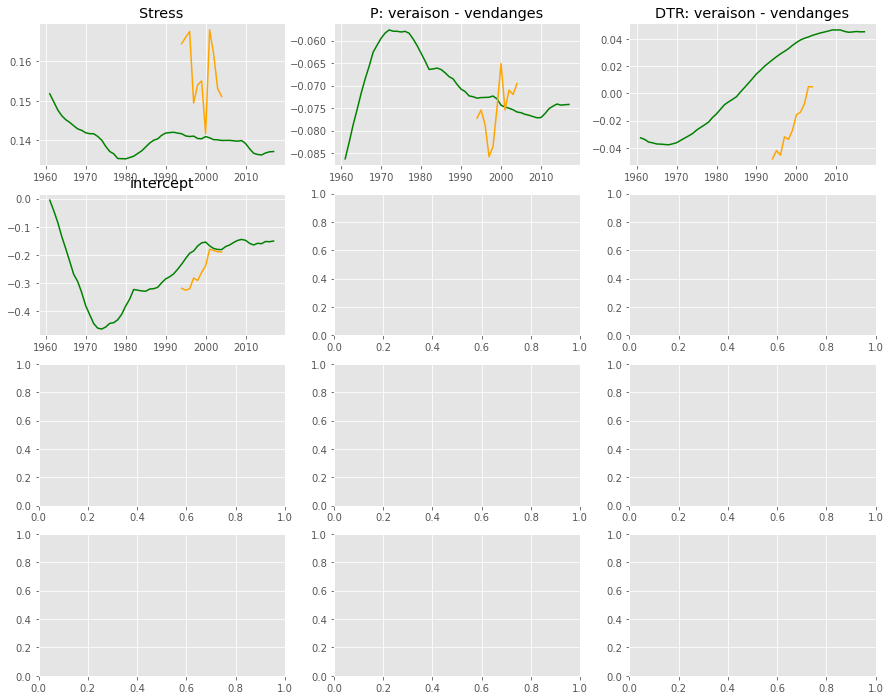

In [137]:
mean_HMC_global = extract_mean_from_trace(trace_global, 1000, model_global)

plt.rcParams['figure.figsize']= [15, 12]
f, axs = plt.subplots(4, 3)
coeff_list = list(mean_HMC_global.keys())
for i in range(len(coeff_list)):
    coeff = coeff_list[i]
    print(coeff_record[coeff])

    subplot = axs[i//3, i%3]
    if coeff in scalar_coeffs:
        subplot.plot(range(1961, 2005), [mean_HMC_global[coeff]]*70, color='green')
        subplot.plot(range(1961, 2005), [coeff_record[coeff]]*70, color='orange')

    else:
        subplot.plot(range(1961, 2018), mean_HMC_global[coeff], color='green')
        subplot.plot(range(1994, 2005), coeff_record[coeff], color='orange')
        
    subplot.set_title(coeff)


Spearman correlation: 
0.36363636363636365

R2 score: 
0.021503234676766958


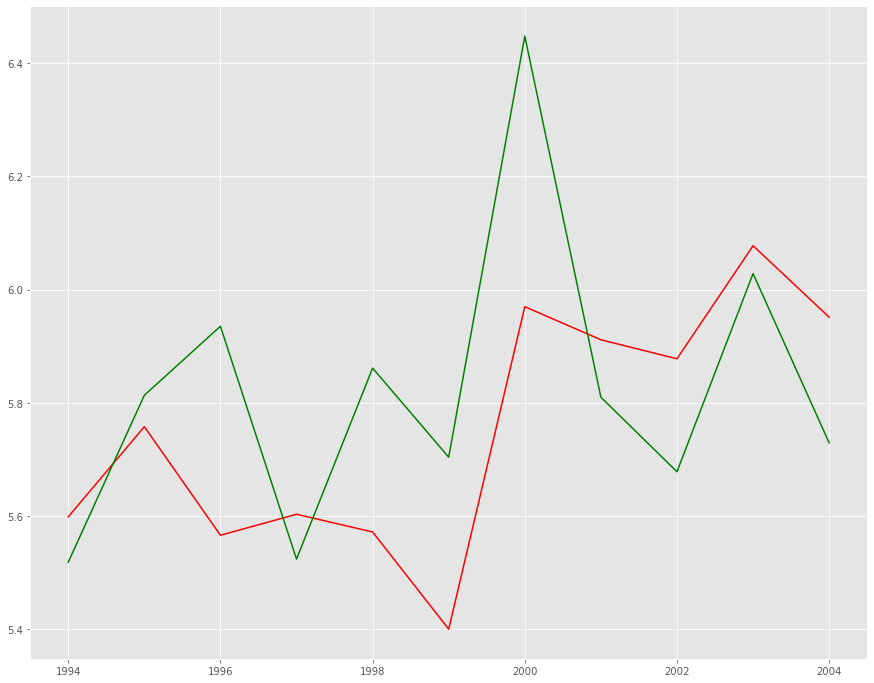

In [138]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

plt.plot(y.loc[1994:2004, 'Log price'].index, predictions, color='r')
plt.plot(y.loc[1994:2004, 'Log price'], color='g')

print('\nSpearman correlation: ')
print(spearmanr(y.loc[1994:2004, 'Log price'], predictions).correlation)

print('\nR2 score: ')
print(r2_score(y.loc[1994:2004, 'Log price'], predictions))

### Avec fenetre maximale, 3 params

Spearman correlation: 
0.36363636363636365

R2 score: 
0.021503234676766958

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

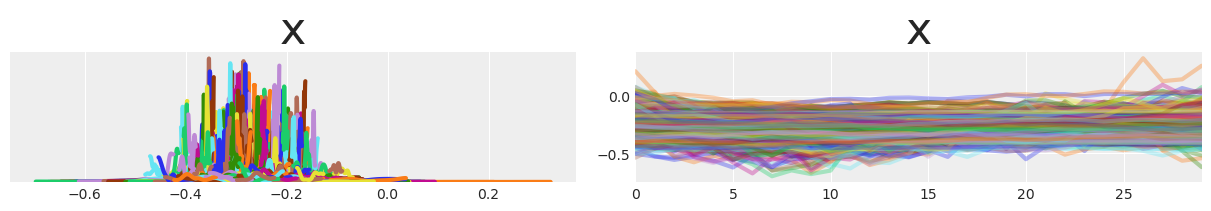